# Data Processing & Micro EDA for LDA 
__Idea Overview__: Topics within reviews associated with particular restaurants should give a general idea about common concepts associated with that restaurant e.g. cleanliness/hygiene, positivity, staff

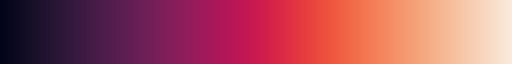

In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from string import punctuation, digits
import seaborn as sns
import matplotlib.pylab as plt

stopwords = stopwords.words("english")
punct = list(punctuation)

sns.color_palette("rocket", as_cmap =True)


__Notebook Objective__: Use this mcdonalds review dataset to make an interesting document collection for testing a scratch implementation of LDA

In [2]:
# Data Source: https://www.kaggle.com/datasets/nelgiriyewithana/mcdonalds-store-reviews
local_source_path = "E:/mcdonalds_nlp/McDonald_s_Reviews.csv"
outpath = "data/mcdonalds_nlp.json"

In [3]:
df = pd.read_csv(local_source_path, encoding="latin-1") #not sure why the encoding is off
punct += ["ï¿½"]
df.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33396 entries, 0 to 33395
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   reviewer_id    33396 non-null  int64  
 1   store_name     33396 non-null  object 
 2   category       33396 non-null  object 
 3   store_address  33396 non-null  object 
 4   latitude       32736 non-null  float64
 5   longitude      32736 non-null  float64
 6   rating_count   33396 non-null  object 
 7   review_time    33396 non-null  object 
 8   review         33396 non-null  object 
 9   rating         33396 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 2.5+ MB


In [5]:
def parse_rating(r):
    return int(r.replace("stars", "").replace("star", "").strip())

df.rename({"latitude ": "latitude"}, inplace=True, axis=1) # random space after column name
df["star_rating"] = df["rating"].map(parse_rating)
df.drop(["category", "latitude", "longitude", "review_time", "store_name", "rating"], axis=1, inplace=True)

<Axes: title={'center': 'Reviews Per Store'}, ylabel='Density'>

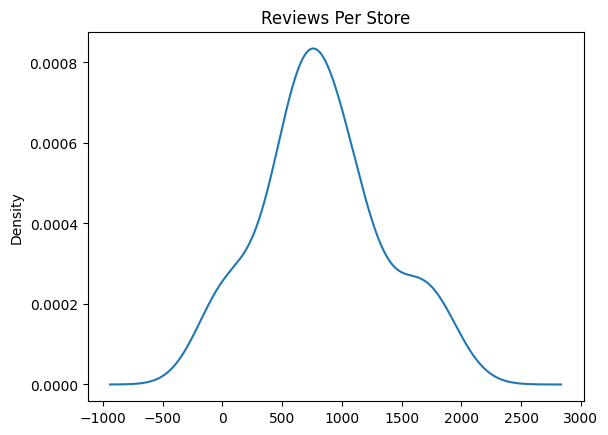

In [6]:
# I'm thinking we collect reviews by store and call each one a document for a handful of stores
df["store_address"].value_counts().plot(kind="kde", title="Reviews Per Store")

In [7]:
grouped = df.groupby("store_address").size()
keeps = grouped[grouped > 800].index #arbritray cut off
df = df[df["store_address"].isin(keeps)]
df.reset_index(inplace=True, drop=True)
df.shape

(23475, 5)

In [8]:
df["store_address"].unique()

array(['1698 US-209, Brodheadsville, PA 18322, United States',
       '72-69 Kissena Blvd, Queens, NY 11367, United States',
       '429 7th Ave, New York, NY 10001, United States',
       '724 Broadway, New York, NY 10003, United States',
       '490 8th Ave, New York, NY 10001, United States',
       '210 5th S, Salt Lake City, UT 84106, United States',
       '1540 2nd St, Santa Monica, CA 90405, United States',
       '8500 US-290, Austin, TX 78724, United States',
       '10901 Riverside Dr, North Hollywood, CA 91602, United States',
       '702-2 Haddonfield-Berlin Rd, Voorhees Township, NJ 08043, United States',
       '1100 N US Hwy 377, Roanoke, TX 76262, United States',
       '621 Broadway, Newark, NJ 07104, United States',
       '2400 Alliance Gateway Fwy, Fort Worth, TX 76177, United States',
       'By Mandalay Bay, 3999 S Las Vegas Blvd, Las Vegas, NV 89119, United States',
       '5725 W Irlo Bronson Memorial Hwy, Kissimmee, FL 34746, United States',
       '1415 E Sta

In [9]:
df["short_address"] = df["store_address"].map(lambda x: x.split(",")[0])

In [10]:
def naive_tokenizer(text):
    for p in punct + list(digits):
        text = text.replace(p, "")
    text = [token.lower() for token in text.split() if token.lower() not in stopwords]
    return text

test = naive_tokenizer("McDonald's restaurants sell food. Lots of chicken. Stuff like that. Sometimes they have 100s of Pokemon cards!")
test

['mcdonalds',
 'restaurants',
 'sell',
 'food',
 'lots',
 'chicken',
 'stuff',
 'like',
 'sometimes',
 'pokemon',
 'cards']

In [11]:
df["tokens"] = df["review"].map(naive_tokenizer)
df["n_tokens"] = df["tokens"].map(len)
df.head()

,reviewer_id,store_address,rating_count,review,star_rating,short_address,tokens,n_tokens
0,801,"1698 US-209, Brodheadsville, PA 18322, United ...","1,028",Horrible customer service! Ordered 2 large fri...,1,1698 US-209,"[horrible, customer, service, ordered, large, ...",38
1,802,"1698 US-209, Brodheadsville, PA 18322, United ...","1,028",Not only did my whole family and I wait on the...,1,1698 US-209,"[whole, family, wait, drive, line, min, fact, ...",24
2,803,"1698 US-209, Brodheadsville, PA 18322, United ...","1,028",Not worth the effort to get in and out of cons...,4,1698 US-209,"[worth, effort, get, construction, wait, old, ...",89
3,804,"1698 US-209, Brodheadsville, PA 18322, United ...","1,028",I used the drive thru today.\nIt was quick.\nF...,5,1698 US-209,"[used, drive, thru, today, quick, free, street...",39
4,805,"1698 US-209, Brodheadsville, PA 18322, United ...","1,028",No one cares about walk-ins anymore. Staff onl...,1,1698 US-209,"[one, cares, walkins, anymore, staff, give, at...",22


Text(0.5, 1.0, 'Review Lengths by Store')

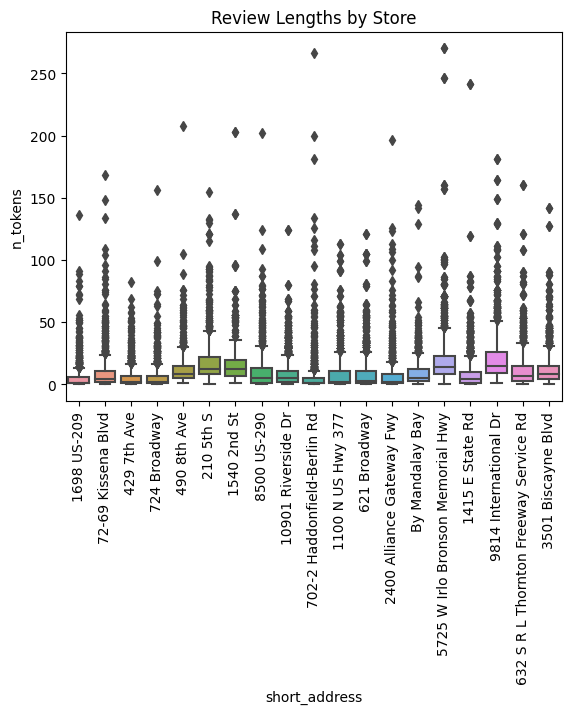

In [12]:
sns.boxplot(data=df, x="short_address", y="n_tokens")
plt.xticks(rotation=90)
plt.title("Review Lengths by Store")

In [13]:
# number of tokens per restaurant document
df.groupby("store_address")["n_tokens"].sum().sort_values(ascending=False)

store_address
9814 International Dr, Orlando, FL 32819, United States                       39435
5725 W Irlo Bronson Memorial Hwy, Kissimmee, FL 34746, United States          32158
632 S R L Thornton Freeway Service Rd, Dallas, TX 75203, United States        19691
3501 Biscayne Blvd, Miami, FL 33137, United States                            19268
210 5th S, Salt Lake City, UT 84106, United States                            16746
10901 Riverside Dr, North Hollywood, CA 91602, United States                  15771
1415 E State Rd, Fern Park, FL 32730, United States                           15148
1540 2nd St, Santa Monica, CA 90405, United States                            13296
621 Broadway, Newark, NJ 07104, United States                                 11986
490 8th Ave, New York, NY 10001, United States                                11073
72-69 Kissena Blvd, Queens, NY 11367, United States                           10849
1100 N US Hwy 377, Roanoke, TX 76262, United States           

Text(0.5, 1.0, 'Restaurant Rating Proportions')

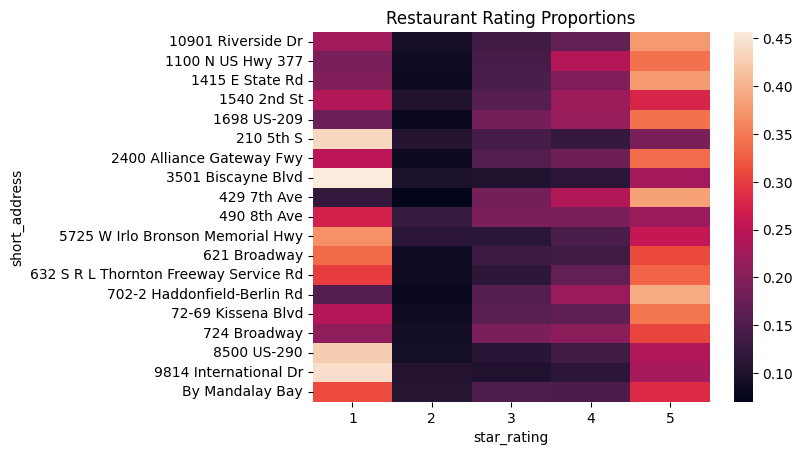

In [14]:
sns.heatmap(df.groupby("short_address")["star_rating"].value_counts(normalize=True).unstack())
plt.title("Restaurant Rating Proportions")
# already interesting that nobody seems to give 2 stars?

In [15]:
# create full docs for each store
store_docs = df.groupby(["store_address", "short_address"])["tokens"].apply(lambda x: sum(x, [])).reset_index()
store_docs["types"] = store_docs["tokens"].map(set)
store_docs

,store_address,short_address,tokens,types
0,"10901 Riverside Dr, North Hollywood, CA 91602,...",10901 Riverside Dr,"[looks, like, chicken, nuggets, bite, piece, s...","{fact, napkin, nice, especially, mind, worth, ..."
1,"1100 N US Hwy 377, Roanoke, TX 76262, United S...",1100 N US Hwy 377,"[perhaps, poorly, run, mcdonalds, texas, visit...","{mango, nice, especially, mind, worth, stars, ..."
2,"1415 E State Rd, Fern Park, FL 32730, United S...",1415 E State Rd,"[speed, service, poor, waited, line, mins, rec...","{fact, families, nice, especially, mind, worth..."
3,"1540 2nd St, Santa Monica, CA 90405, United St...",1540 2nd St,"[theres, nothing, like, eating, spicy, mc, chi...","{fact, mango, families, napkin, nice, especial..."
4,"1698 US-209, Brodheadsville, PA 18322, United ...",1698 US-209,"[horrible, customer, service, ordered, large, ...","{complimentary, fact, ballpits, nice, especial..."
5,"210 5th S, Salt Lake City, UT 84106, United St...",210 5th S,"[quick, stop, bite, tide, us, couple, kids, us...","{complimentary, fact, nice, especially, mind, ..."
6,"2400 Alliance Gateway Fwy, Fort Worth, TX 7617...",2400 Alliance Gateway Fwy,"[daughter, came, drive, big, mac, prepared, se...","{fact, nice, loading, especially, mind, worth,..."
7,"3501 Biscayne Blvd, Miami, FL 33137, United St...",3501 Biscayne Blvd,"[place, clean, nice, got, food, quick, order, ...","{fact, digging, nice, especially, series, educ..."
8,"429 7th Ave, New York, NY 10001, United States",429 7th Ave,"[visited, location, breakfast, place, small, b...","{fact, nice, especially, skyscrapers, worth, s..."
9,"490 8th Ave, New York, NY 10001, United States",490 8th Ave,"[two, stars, given, star, carla, made, visit, ...","{fact, digging, families, nice, especially, ex..."


In [16]:
full_vocab = set().union(*store_docs["types"])
f"Unique tokens: {len(full_vocab)}"

'Unique tokens: 11713'

In [17]:
from collections import Counter
vocab_dict = {k:0 for k in sorted(full_vocab)}

def vocab_counts(tokens):
    c = vocab_dict.copy()
    c.update(Counter(tokens))
    return c

store_docs["token_frequencies"] = store_docs["tokens"].map(vocab_counts)
store_docs

,store_address,short_address,tokens,types,token_frequencies
0,"10901 Riverside Dr, North Hollywood, CA 91602,...",10901 Riverside Dr,"[looks, like, chicken, nuggets, bite, piece, s...","{fact, napkin, nice, especially, mind, worth, ...","{'aa': 2, 'aaaah': 0, 'aaand': 0, 'aak': 0, 'a..."
1,"1100 N US Hwy 377, Roanoke, TX 76262, United S...",1100 N US Hwy 377,"[perhaps, poorly, run, mcdonalds, texas, visit...","{mango, nice, especially, mind, worth, stars, ...","{'aa': 0, 'aaaah': 0, 'aaand': 0, 'aak': 0, 'a..."
2,"1415 E State Rd, Fern Park, FL 32730, United S...",1415 E State Rd,"[speed, service, poor, waited, line, mins, rec...","{fact, families, nice, especially, mind, worth...","{'aa': 2, 'aaaah': 0, 'aaand': 0, 'aak': 0, 'a..."
3,"1540 2nd St, Santa Monica, CA 90405, United St...",1540 2nd St,"[theres, nothing, like, eating, spicy, mc, chi...","{fact, mango, families, napkin, nice, especial...","{'aa': 0, 'aaaah': 0, 'aaand': 0, 'aak': 0, 'a..."
4,"1698 US-209, Brodheadsville, PA 18322, United ...",1698 US-209,"[horrible, customer, service, ordered, large, ...","{complimentary, fact, ballpits, nice, especial...","{'aa': 0, 'aaaah': 0, 'aaand': 0, 'aak': 0, 'a..."
5,"210 5th S, Salt Lake City, UT 84106, United St...",210 5th S,"[quick, stop, bite, tide, us, couple, kids, us...","{complimentary, fact, nice, especially, mind, ...","{'aa': 0, 'aaaah': 0, 'aaand': 0, 'aak': 0, 'a..."
6,"2400 Alliance Gateway Fwy, Fort Worth, TX 7617...",2400 Alliance Gateway Fwy,"[daughter, came, drive, big, mac, prepared, se...","{fact, nice, loading, especially, mind, worth,...","{'aa': 0, 'aaaah': 0, 'aaand': 0, 'aak': 0, 'a..."
7,"3501 Biscayne Blvd, Miami, FL 33137, United St...",3501 Biscayne Blvd,"[place, clean, nice, got, food, quick, order, ...","{fact, digging, nice, especially, series, educ...","{'aa': 0, 'aaaah': 0, 'aaand': 0, 'aak': 0, 'a..."
8,"429 7th Ave, New York, NY 10001, United States",429 7th Ave,"[visited, location, breakfast, place, small, b...","{fact, nice, especially, skyscrapers, worth, s...","{'aa': 0, 'aaaah': 0, 'aaand': 0, 'aak': 0, 'a..."
9,"490 8th Ave, New York, NY 10001, United States",490 8th Ave,"[two, stars, given, star, carla, made, visit, ...","{fact, digging, families, nice, especially, ex...","{'aa': 0, 'aaaah': 0, 'aaand': 0, 'aak': 0, 'a..."


In [18]:
all_token_frequencies = vocab_counts(store_docs["tokens"].agg(sum))
# sorted by frequency
all_token_frequencies = {k:v for k, v in sorted(all_token_frequencies.items(), key=lambda x: x[1], reverse=True)}
sum(all_token_frequencies.values())

269672

Text(0.5, 1.0, 'Token Frequencies')

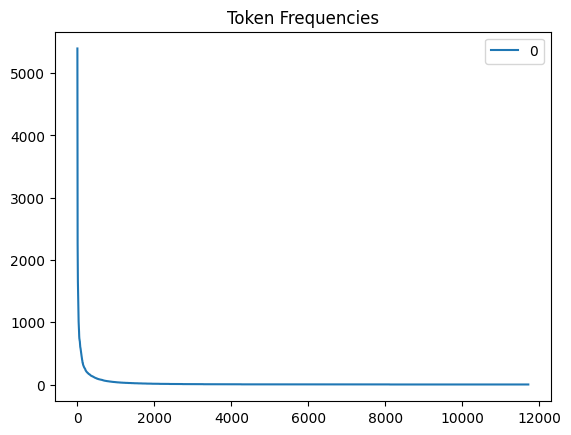

In [19]:
sns.lineplot(all_token_frequencies.values())
plt.title("Token Frequencies")
# this is v extreme power law. 11713 token types will result in too large a vocab size for me
# so let's threshold it

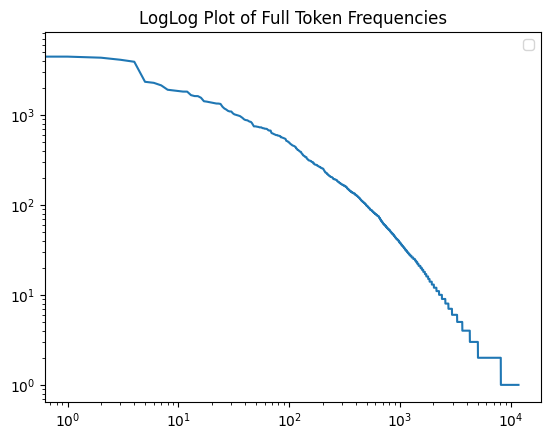

In [20]:
sns.lineplot(all_token_frequencies.values())
plt.xscale("log")
plt.yscale("log")
plt.title("LogLog Plot of Full Token Frequencies")
plt.legend("")
# would expect log-log to be a straight line for Zipf's Law distribution typical of corpora. 
# it's not too far off and this is with stopwords removed which alters the dist

In [21]:
keep_tokens = [t for t, v in all_token_frequencies.items() if v > 5]
len(keep_tokens)
# thats a bit more manageable so we'll work with that

3271

In [22]:
def threshold_types(x):
    return {k:v for k,v in x.items() if k in keep_tokens}

store_docs["tf_limited"] = store_docs["token_frequencies"].map(threshold_types)

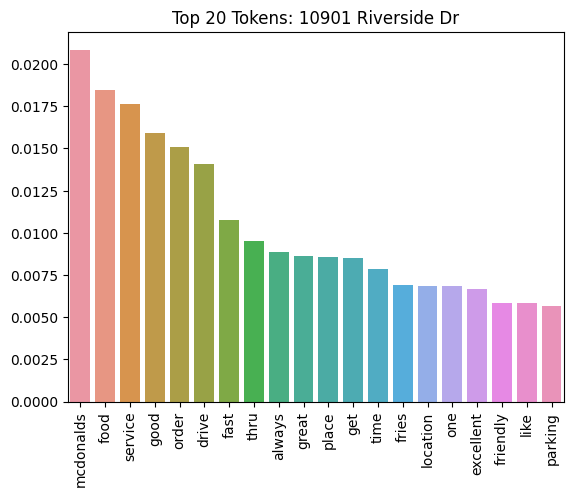

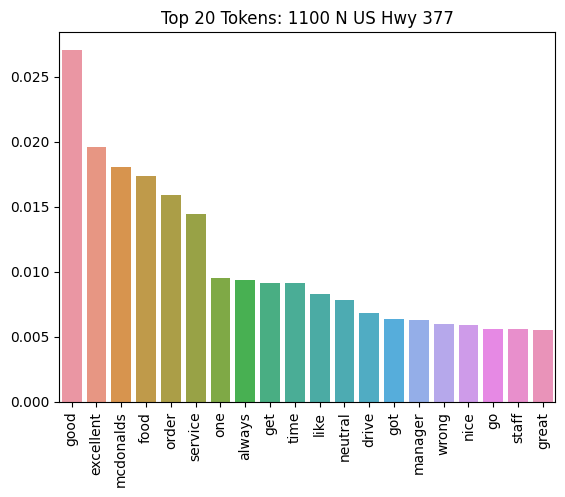

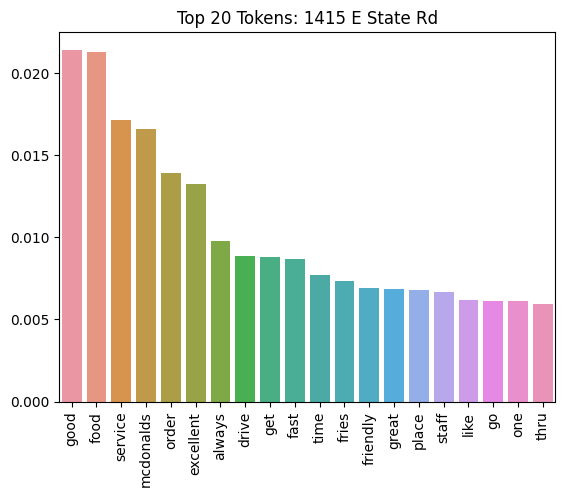

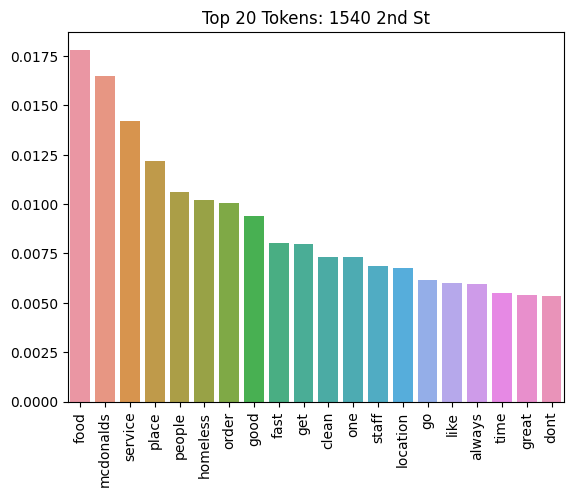

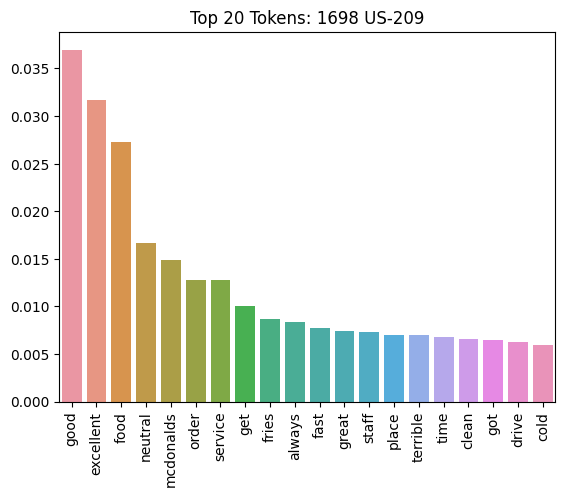

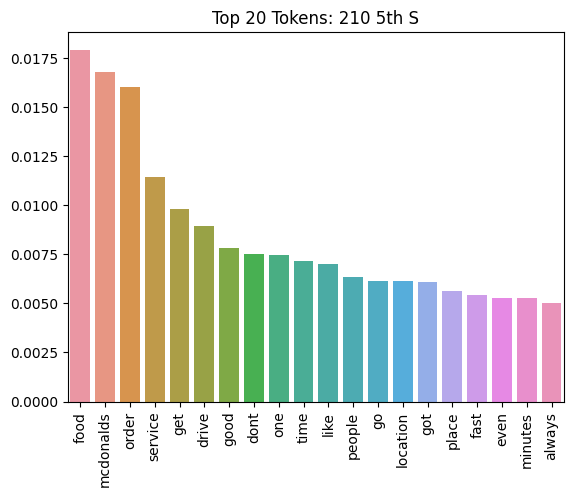

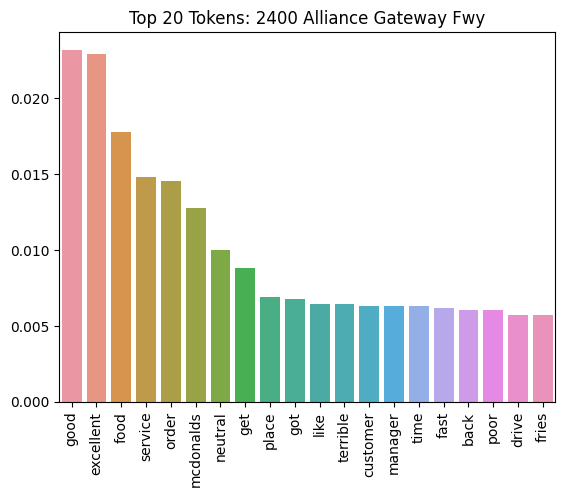

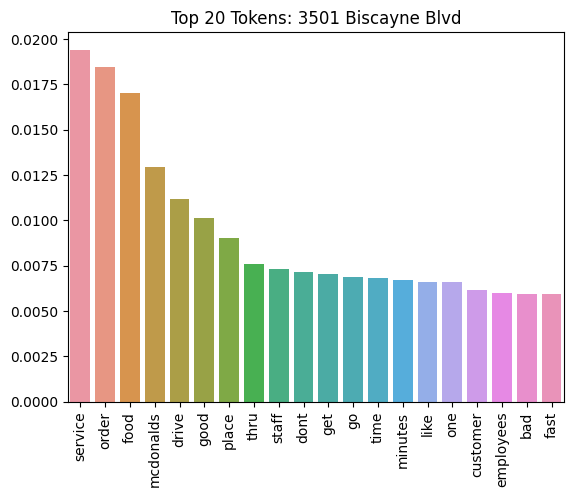

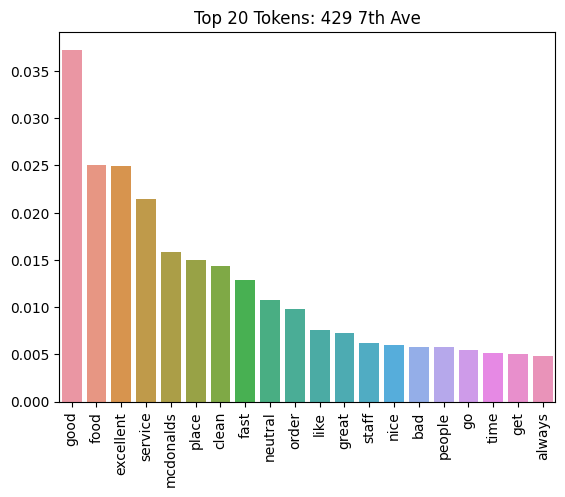

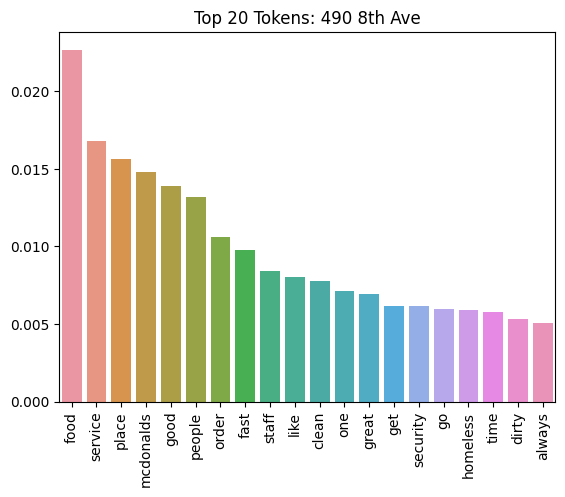

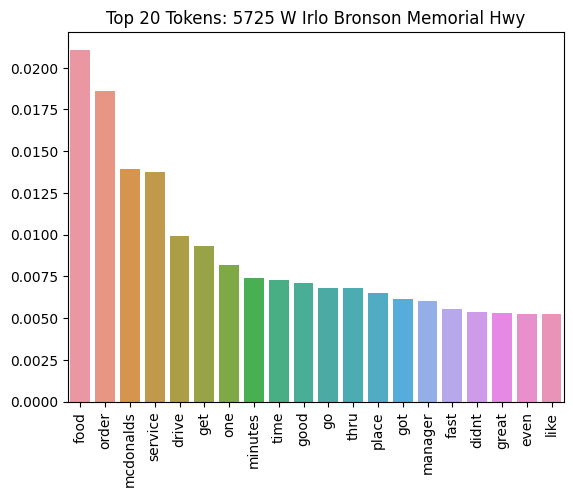

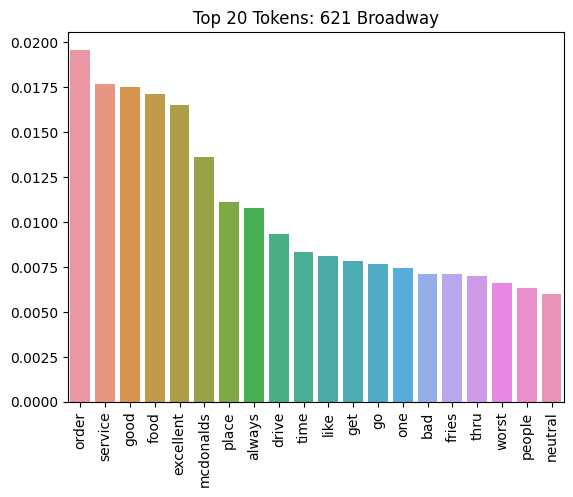

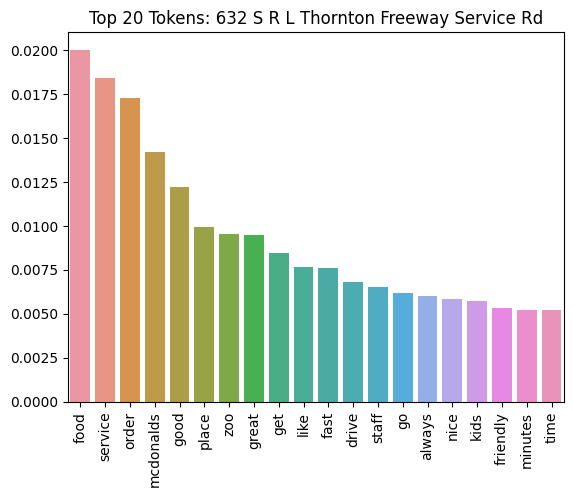

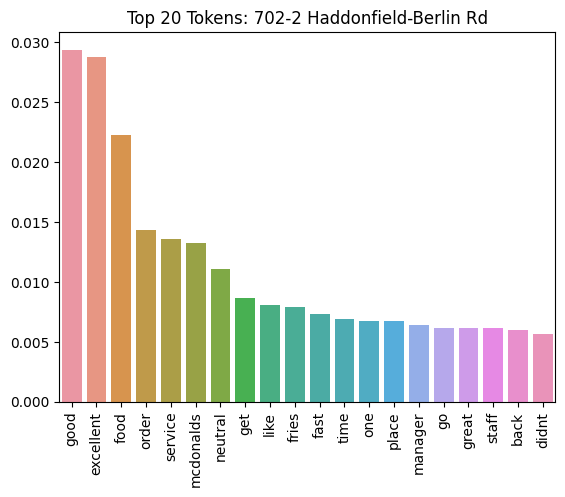

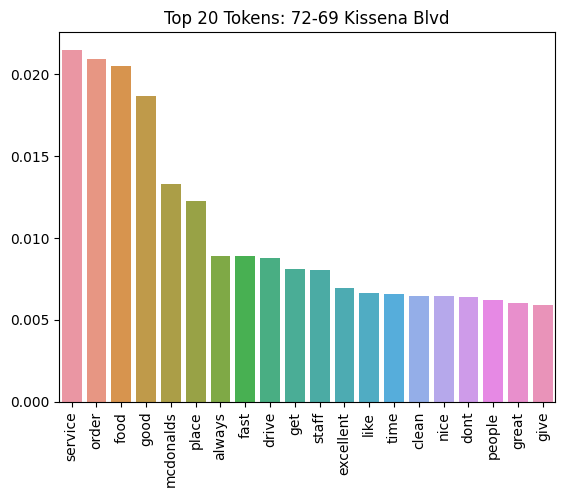

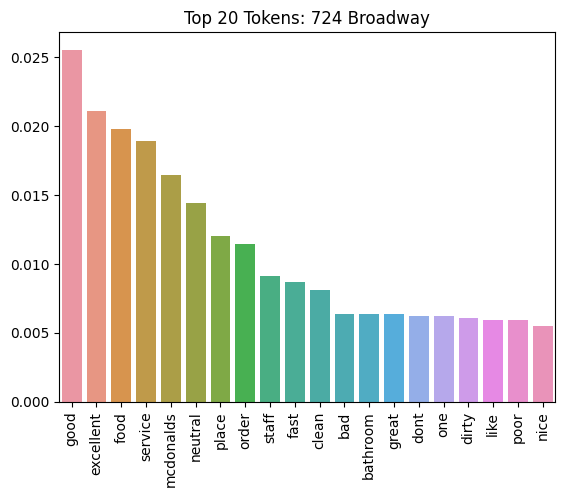

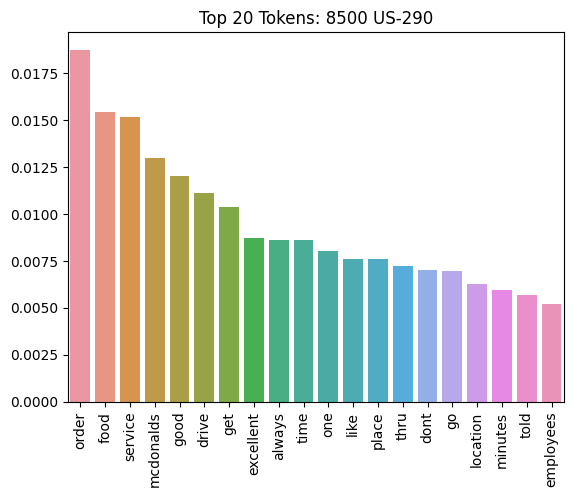

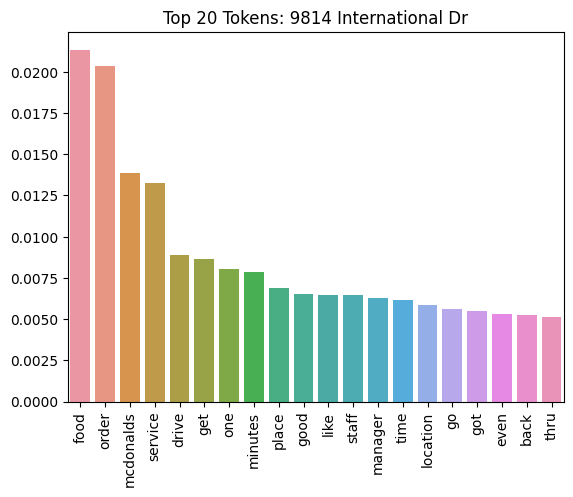

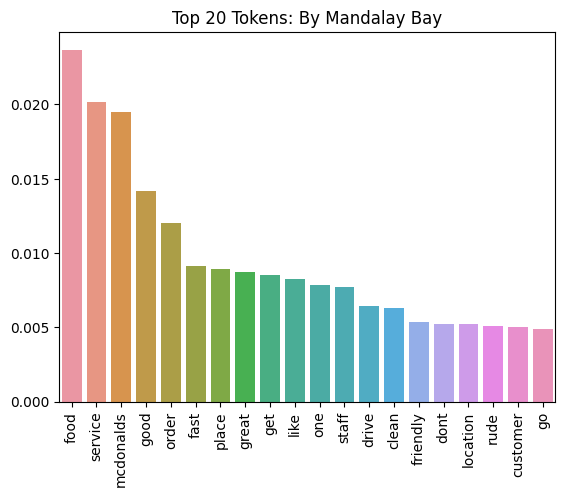

In [23]:
# very simple token frequency analysis by store
for row in store_docs.itertuples():
    s = sum(row.token_frequencies.values())
    freqs = {k:v/s for k, v in sorted(row.token_frequencies.items(), key=lambda x: x[1], reverse=True)[:20]}
    sns.barplot(pd.DataFrame(freqs, index=list(range(len(freqs)))))
    plt.title("Top 20 Tokens: " + row.short_address)
    plt.xticks(rotation=90)
    plt.show()

In [24]:
store_docs.to_json("../lda/" + outpath)